# Solubility Prediction with Random Forest

## Dataset
We use the MoleculeNet benchmark dataset, specifically the ESOL (delaney) dataset for solubility prediction.

In [7]:
pip install --upgrade rdkit-pypi pandas numpy scikit-learn torch matplotlib seaborn libraft-cu12 pylibraft-cu12 rmm-cu12 --break-system-packages

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install rdkit pandas numpy scikit-learn xgboost lightgbm matplotlib seaborn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 59.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip -q install pyg_lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip -q install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 107.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 98.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00a 0:00:01


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  
from torch_geometric.nn import GCNConv, global_mean_pool

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/libpyg.so: undefined symbol: _ZNK5torch8autograd4Node4nameEv
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_g

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
Device: cuda


## 1. Data Loading and Preprocessing

In [6]:
# Load ESOL dataset (solubility prediction)
# Dataset contains SMILES strings and measured solubility values
url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1128, 10)

Column names: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']

First few rows:


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


Dataset Statistics:
Total molecules: 1128

Solubility statistics:
count    1128.000000
mean       -3.050102
std         2.096441
min       -11.600000
25%        -4.317500
50%        -2.860000
75%        -1.600000
max         1.580000
Name: measured log solubility in mols per litre, dtype: float64


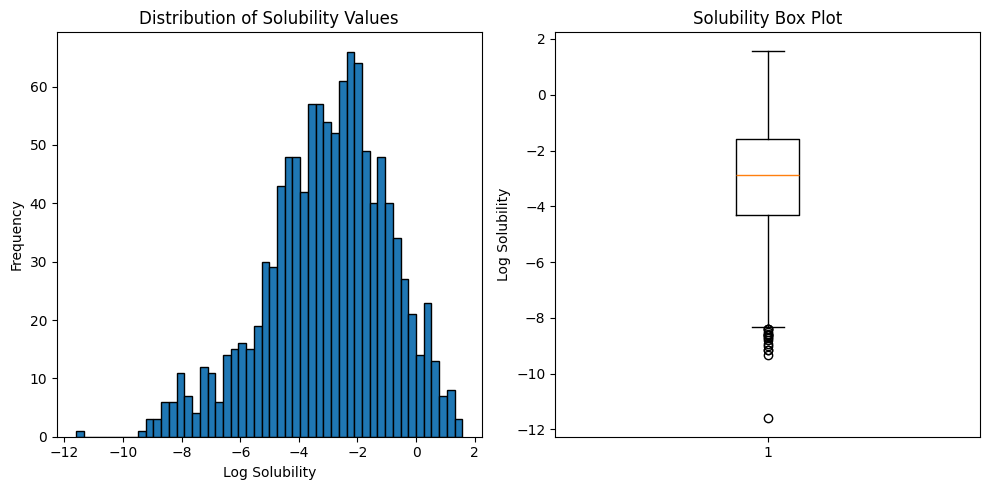

In [7]:
# Basic statistics
print("Dataset Statistics:")
print(f"Total molecules: {len(df)}")
print(f"\nSolubility statistics:")
print(df['measured log solubility in mols per litre'].describe())

# Visualize solubility distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['measured log solubility in mols per litre'], bins=50, edgecolor='black')
plt.xlabel('Log Solubility')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.boxplot(df['measured log solubility in mols per litre'])
plt.ylabel('Log Solubility')
plt.title('Solubility Box Plot')
plt.tight_layout()
plt.show()

## 2. Molecular Featurization

We'll convert SMILES strings to molecular graphs where:
- Nodes represent atoms with features (atom type, charge, etc.)
- Edges represent chemical bonds

In [8]:
def smiles_to_graph(smiles):
    """
    Convert SMILES string to graph representation
    Returns node features, edge indices, and edge features
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Atom features
    atom_features = []
    for atom in mol.GetAtoms():
        # One-hot encoding of atom type
        atom_type = [0] * 10  # Support 10 common atom types
        atom_types = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'other']
        symbol = atom.GetSymbol()
        if symbol in atom_types:
            atom_type[atom_types.index(symbol)] = 1
        else:
            atom_type[-1] = 1
        
        # Additional features
        features = atom_type + [
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetNumRadicalElectrons(),
            atom.GetHybridization().real,
            atom.GetIsAromatic(),
            atom.GetTotalNumHs()
        ]
        atom_features.append(features)
    
    # Edge indices (bonds)
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append([i, j])
        edge_indices.append([j, i])  # Add reverse edge
    
    if len(edge_indices) == 0:
        edge_indices = [[0, 0]]  # Self-loop for isolated atoms
    
    return {
        'x': torch.tensor(atom_features, dtype=torch.float),
        'edge_index': torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    }

# Test the function
test_smiles = df.iloc[0]['smiles']
graph = smiles_to_graph(test_smiles)
print(f"Test molecule: {test_smiles}")
print(f"Number of atoms: {graph['x'].shape[0]}")
print(f"Number of bonds: {graph['edge_index'].shape[1] // 2}")
print(f"Atom feature dimension: {graph['x'].shape[1]}")

Test molecule: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
Number of atoms: 32
Number of bonds: 34
Atom feature dimension: 16


In [9]:
# Convert all molecules to graphs
print("Converting molecules to graphs...")
graph_data = []
valid_indices = []

for idx, row in df.iterrows():
    graph = smiles_to_graph(row['smiles'])
    if graph is not None:
        data = Data(
            x=graph['x'],
            edge_index=graph['edge_index'],
            y=torch.tensor([row['measured log solubility in mols per litre']], dtype=torch.float)
        )
        graph_data.append(data)
        valid_indices.append(idx)

print(f"Successfully converted {len(graph_data)} molecules")
print(f"Failed conversions: {len(df) - len(graph_data)}")

Converting molecules to graphs...
Successfully converted 1128 molecules
Failed conversions: 0


## 3. Traditional ML Baseline - Random Forest with Morgan Fingerprints

In [10]:
from rdkit import rdBase

rdBase.DisableLog("rdApp.warning")
def mol_to_fingerprint(smiles, radius=2, n_bits=2048):
    """Convert SMILES to Morgan fingerprint"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

# Generate fingerprints
print("Generating Morgan fingerprints...")
fingerprints = []
targets = []

for idx in valid_indices:
    fp = mol_to_fingerprint(df.iloc[idx]['smiles'])
    if fp is not None:
        fingerprints.append(fp)
        targets.append(df.iloc[idx]['measured log solubility in mols per litre'])

X_fp = np.array(fingerprints)
y_fp = np.array(targets)

print(f"Fingerprint matrix shape: {X_fp.shape}")

Generating Morgan fingerprints...
Fingerprint matrix shape: (1128, 2048)


In [11]:
# Split data
X_train_fp, X_test_fp, y_train_fp, y_test_fp = train_test_split(
    X_fp, y_fp, test_size=0.2, random_state=42
)

# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_fp, y_train_fp)

# Evaluate
y_pred_train_rf = rf_model.predict(X_train_fp)
y_pred_test_rf = rf_model.predict(X_test_fp)

print("\nRandom Forest Results:")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_fp, y_pred_train_rf)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_fp, y_pred_test_rf)):.4f}")
print(f"Train R²: {r2_score(y_train_fp, y_pred_train_rf):.4f}")
print(f"Test R²: {r2_score(y_test_fp, y_pred_test_rf):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test_fp, y_pred_test_rf):.4f}")

Training Random Forest...

Random Forest Results:
Train RMSE: 0.5072
Test RMSE: 1.1631
Train R²: 0.9403
Test R²: 0.7138
Test MAE: 0.8825


## 5. Model Evaluation and Comparison

In [18]:
# Final evaluation
train_rmse, train_mae, train_r2, train_preds, train_targets = evaluate(model, train_loader, device)
test_rmse, test_mae, test_r2, test_preds, test_targets = evaluate(model, test_loader, device)

print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)
print("\nRandom Forest (Morgan Fingerprints):")
print(f"  Test RMSE: {np.sqrt(mean_squared_error(y_test_fp, y_pred_test_rf)):.4f}")
print(f"  Test R²: {r2_score(y_test_fp, y_pred_test_rf):.4f}")
print(f"  Test MAE: {mean_absolute_error(y_test_fp, y_pred_test_rf):.4f}")




FINAL MODEL COMPARISON

Random Forest (Morgan Fingerprints):
  Test RMSE: 1.1631
  Test R²: 0.7138
  Test MAE: 0.8825


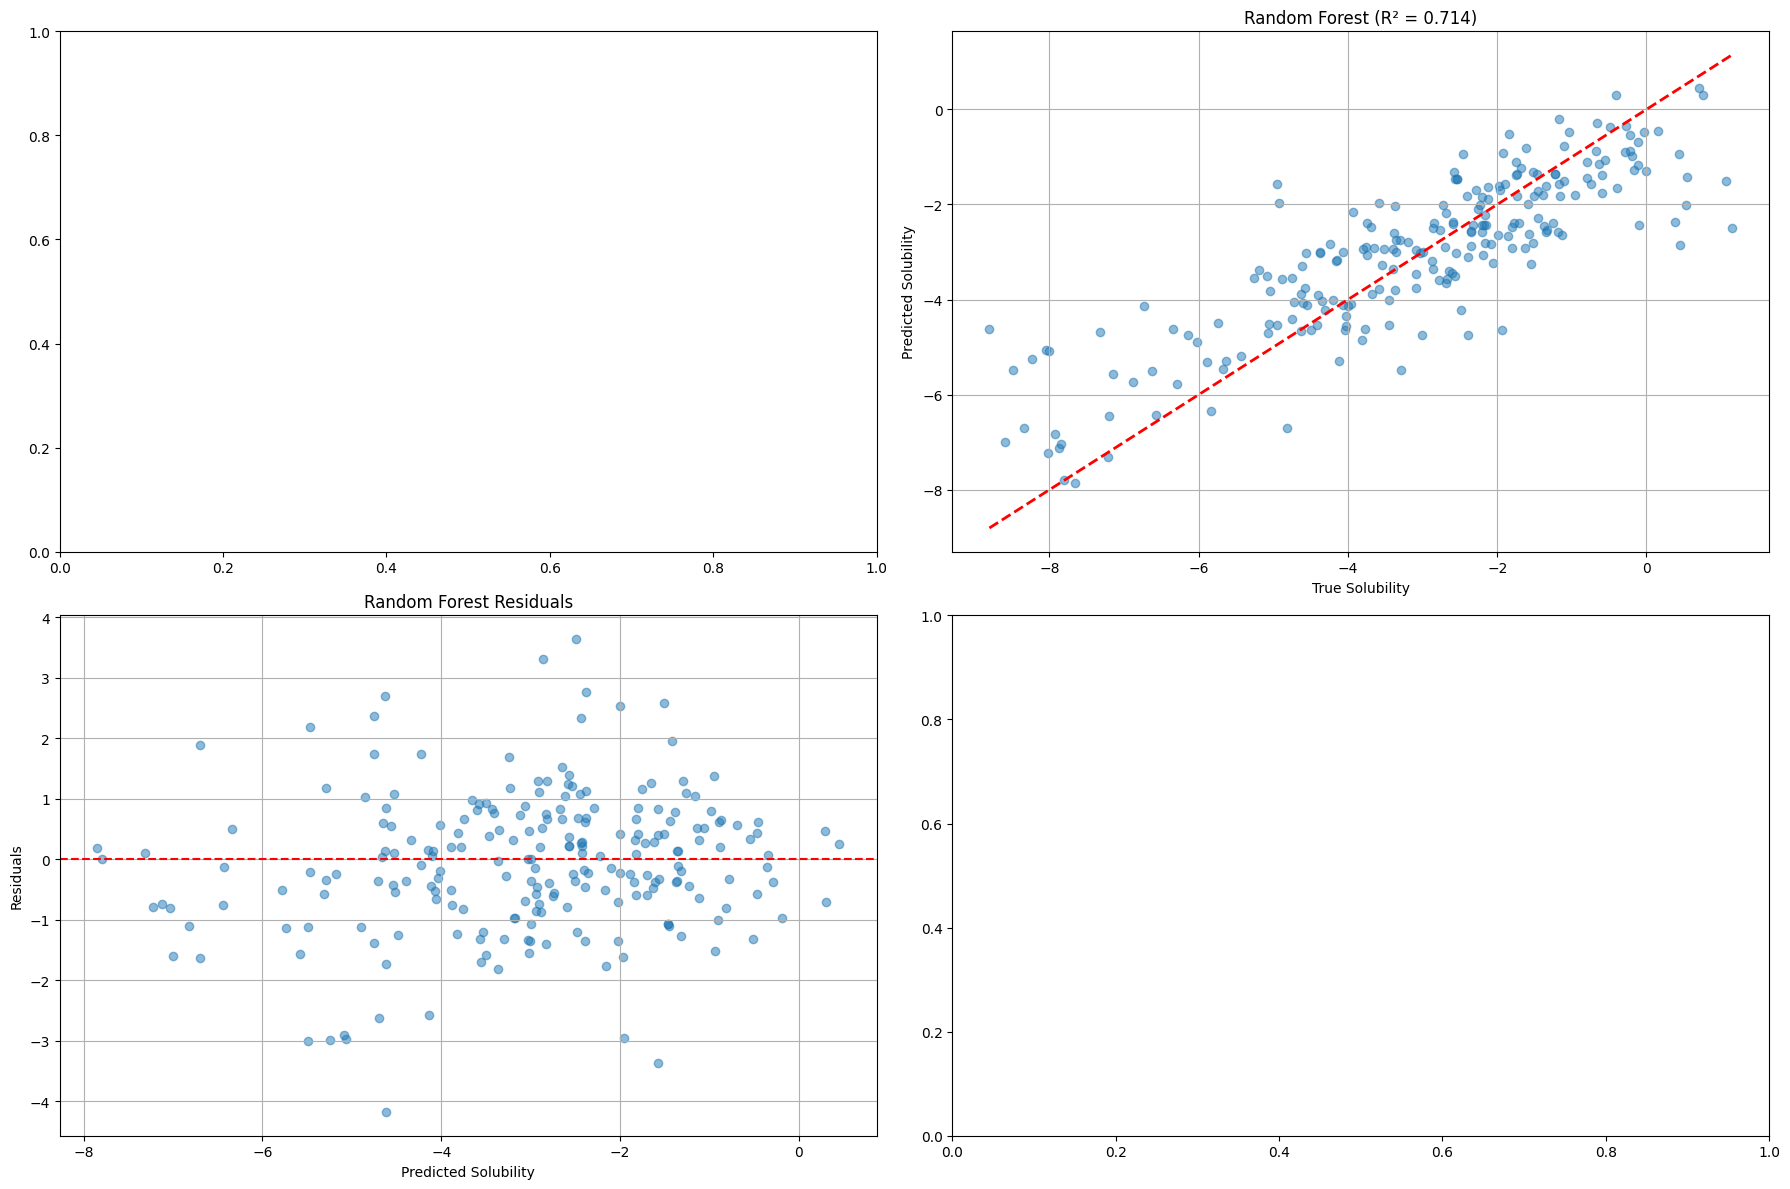

In [25]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))


# RF predictions
axes[0, 1].scatter(y_test_fp, y_pred_test_rf, alpha=0.5)
axes[0, 1].plot([y_test_fp.min(), y_test_fp.max()], [y_test_fp.min(), y_test_fp.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('True Solubility')
axes[0, 1].set_ylabel('Predicted Solubility')
axes[0, 1].set_title(f'Random Forest (R² = {r2_score(y_test_fp, y_pred_test_rf):.3f})')
axes[0, 1].grid(True)


# Residuals RF
residuals_rf = y_test_fp - y_pred_test_rf
axes[1, 0].scatter(y_pred_test_rf, residuals_rf, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Solubility')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Random Forest Residuals')
axes[1, 0].grid(True)


plt.tight_layout()

plt.show()


## 7. Inference on New Molecules

In [17]:
# 7. Inference on New Molecules

def predict_solubility(smiles_list, model, device):
    """
    Predict solubility for a list of SMILES strings
    """
    model.eval()
    predictions = []
    
    for smiles in smiles_list:
        graph = smiles_to_graph(smiles)
        if graph is None:
            predictions.append(None)
            continue
        
        data = Data(
            x=graph['x'],
            edge_index=graph['edge_index'],
            batch=torch.zeros(graph['x'].shape[0], dtype=torch.long)
        ).to(device)
        
        with torch.no_grad():
            pred = model(data).item()
            predictions.append(pred)
    
    return predictions

# Test on example molecules
example_molecules = [
    ('Ibuprofen', 'CC(C)Cc1ccc(cc1)C(C)C(O)=O'),
    ('Aspirin', 'CC(=O)Oc1ccccc1C(=O)O'),
    ('Caffeine', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'),
    ('Paracetamol', 'CC(=O)Nc1ccc(O)cc1'),  
    ('Warfarin', 'CC(=O)CC(c1ccccc1)c2c(O)c3ccccc3oc2=O')
]

predictions = predict_solubility([smile for _, smile in example_molecules], model, device)

print('\n' + '='*80)
print('SOLUBILITY PREDICTIONS FOR COMMON DRUGS')
print('='*80)
print(f"{'Drug':<15} | {'SMILES':<35} | {'Log(S)':<10} | {'Solubility':<15}")
print('-'*80)

for (name, smiles), pred in zip(example_molecules, predictions):
    if pred is not None:
        # Interpret the prediction
        if pred > -2:
            solubility = "Highly Soluble"
        elif pred > -4:
            solubility = "Moderately Soluble"
        else:
            solubility = "Poorly Soluble"
        
        print(f"{name:<15} | {smiles:<35} | {pred:>7.3f}    | {solubility:<15}")

print('='*80)
print('\nInterpretation:')
print('  Log(S) > -2:  Highly soluble (good oral bioavailability)')
print('  Log(S) -2 to -4: Moderate solubility (acceptable for most drugs)')
print('  Log(S) < -4:  Poorly soluble (formulation challenges)')



SOLUBILITY PREDICTIONS FOR COMMON DRUGS
Drug            | SMILES                              | Log(S)     | Solubility     
--------------------------------------------------------------------------------
Ibuprofen       | CC(C)Cc1ccc(cc1)C(C)C(O)=O          |  -3.019    | Moderately Soluble
Aspirin         | CC(=O)Oc1ccccc1C(=O)O               |  -2.999    | Moderately Soluble
Caffeine        | CN1C=NC2=C1C(=O)N(C(=O)N2C)C        |  -3.200    | Moderately Soluble
Paracetamol     | CC(=O)Nc1ccc(O)cc1                  |  -3.090    | Moderately Soluble
Warfarin        | CC(=O)CC(c1ccccc1)c2c(O)c3ccccc3oc2=O |  -3.055    | Moderately Soluble

Interpretation:
  Log(S) > -2:  Highly soluble (good oral bioavailability)
  Log(S) -2 to -4: Moderate solubility (acceptable for most drugs)
  Log(S) < -4:  Poorly soluble (formulation challenges)
